## Build Score Model

### Objective

* Creates the comprehensive set of scoring models for all players and courses in the database, using an ElasticNetCV linear regression for weather parameters when a player has sufficient games on the same course, an ARIMA(0,1,0) model when a player has 4 or more game on the same course but not enough for a weather-based model, a same-course average if the player has one or more games on the same course, and an off-course average when a player has no games on the same course.  Also computes an estimated error from (in order of preference), same-course mse, all-course mse, or, when there is only one game available, an imputed first-vs-second game sme on either the same course or all-course, as the situation requires.  

### Rationale

*  Why This?  The models are a key component of the service offered by the system, and need a production-ready ETL method

*  Why Me?  As the main model architect, I am the logical choice

*  Why Now?  Successful trial runs with earlier models have accomplished preliminary optimization and established usefulness with user feedback.  Having a production-level model-building system now will enable us to receive maximum benefit from early deployments.

### Requirements

*  Pandas 0.24.2
*  Scikit-learn 0.21.2
*  Numpy 1.16.4
*  Matplotlib 3.1.0

### Input / Output

*  This notebook is expected to be in `models/notebooks`

*  The input weather data is in a file `models/wx_model_data/wx_model.csv`

*  The input score data is in a file `models/score_model_data/scores.csv`

*  The output models are stored in a file `models/score_model_data/score_model.csv` with a second copy as `models/scoer_model_data/score_model_{YYYYMMDD}{[a-z]}` where YYYYMMDD is the year, month, and day the model was generated, and a lower-case letter auto-increments for tracking.  `score_model.csv` is moved to `scoreCalculator/data` for deployed use.

### Import / Set-Up

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get weather data
wx_df = pd.read_csv('../wx_model_data/wx_model.csv', parse_dates = ['date'])
# Get scores data
scores_df = pd.read_csv('../score_model_data/scores.csv', parse_dates = ['time'])

In [3]:
wx_df.head()

,Unnamed: 0,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var,course_id
0,0,2018-12-09,49.491667,68.116667,3.919444,13.133333,90.988889,0.000000,2.100778,2.822686,2.915556,490.203981,41.108702,0
1,1,2019-01-27,56.642593,66.362963,3.916667,12.466667,73.714815,0.000000,2.674324,2.326601,1.582222,301.056529,227.954035,0
2,2,2018-11-11,62.987163,59.560057,5.091894,15.866667,26.821613,0.000000,2.632290,3.792724,2.382222,115.436274,111.370212,0
3,3,2019-02-03,53.603704,243.125926,6.662963,20.400000,91.900000,0.001870,-5.654134,-2.807737,6.106667,17.509657,49.623507,0
4,4,2019-01-06,51.505556,153.133333,4.384722,20.933333,89.798611,0.105625,0.829178,-3.227827,6.995556,214.376551,906.500313,0


In [12]:
scores_df.head()

,id,Name,Raw,Handicap,Adjusted,time,course_id
0,0,Mark Shannon,61,-12.40,48.60,2019-01-19 08:00:00,1
1,1,Jacob Kermish-Wells,60,-10.72,49.28,2019-01-19 08:00:00,1
2,2,Luiz Celeste,55,-5.23,49.77,2019-01-19 08:00:00,1
3,3,Tu Tran,59,-9.07,49.93,2019-01-19 08:00:00,1
4,4,Matty Angell,53,-1.50,51.50,2019-01-19 08:00:00,1


In [13]:
# Clean out duplicated indexes
wx_df = wx_df.drop(columns = 'Unnamed: 0')
scores_df = scores_df.drop(columns = 'id')

In [14]:
# Sort prior to merge
wx_df = wx_df.sort_values(by = ['date','course_id'])
scores_df = scores_df.sort_values(by= ['time','course_id','Name'])

In [15]:
# Merge
all_df = pd.merge_asof(scores_df, wx_df, by = 'course_id', left_on= 'time', right_on = 'date',
                       direction = 'backward', tolerance = pd.Timedelta('1d') )
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
0,Alex Torres,68,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andy Leaf,53,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anthony McGinnis,78,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aurelius Lewicki,57,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Billy Manger,58,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prepare imputation estimates 

* Use as needed for when players have only ever played once or got an unrealistically low variation in scores:
    * Single game on current course only -- use 1st game mean and historical 1st/2nd game average mse for all players on course
    * Single game on a different course -- use existing game mean and historical 1st/2nd game (different course) average mse for all players
    * Low standard deviation cut-off -- use the 5th percentile of all observed standard deviations

In [16]:
# Generate different course 1st to 2nd game estimate
player_names = all_df['Name'].unique()
diffs = []
for player in player_names:
    player_df = all_df[all_df['Name'] == player].sort_values(by = 'time')
    if len(player_df) > 1:
        scores = player_df[['course_id','Raw']].groupby('course_id')['Raw'].first().values
        if len(scores) > 1:
            diffs.append(scores[1] - scores[0])
if len(diffs) > 1:
    mse1to2_different_course = np.std(diffs) * np.std(diffs)
else:
    mse1to2_different_course = 6 * 6
mse1to2_different_course

37.30478395061729

In [17]:
# Generate same course 1st to 2nd game estimate
mse1to2_same_course = []
for course_num in range(all_df['course_id'].max() + 1):
    same_course_df = all_df[all_df['course_id'] == course_num]
    player_names = same_course_df['Name'].unique()
    diffs = []
    for player in player_names:
        player_df = same_course_df[same_course_df['Name'] == player].sort_values(by = 'time')
        if len(player_df) > 1:
            scores = player_df['Raw'].tolist()
            if len(scores) > 1:
                diffs.append(scores[1] - scores[0])
    if len(diffs) > 1:
        mse1to2_same_course.append(np.std(diffs) * np.std(diffs))
    else:
        mse1to2_same_course.append(6 * 6)
mse1to2_same_course

[28.547822339223522, 32.90227440828402, 33.77324263038549]

In [18]:
# Generate low standard deviation cut-off at 5th percentile 
player_stdev = all_df[['Name','Raw']].groupby('Name').std()
low_std_cutoff = player_stdev['Raw'].quantile(q=0.05)
low_var_cutoff = low_std_cutoff * low_std_cutoff
low_var_cutoff

1.1112220782958926

### Build models

In [19]:
# Drop any rows from all_df that do not have weather data
all_df = all_df.dropna(subset = ['weighted_T'])
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
478,Ben Horst,65,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
479,Bob Montes,54,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
480,Dennis Warsen,52,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
481,Gonzalo Arestizabal,63,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
482,Greg Mann,58,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685


In [70]:
def model_player_performance(player : str, course : int):
    """Given a player name and course id, return model parameters indicating the effects of weather on expected score.
    The model will return a dictionary with coefficients for easy identification.  This funciton uses global values
    that must be previously computed and available."""
    
    model_dict = {}
    model_dict['player'] = player
    model_dict['course_id'] = course
    player_df = all_df[(all_df['Name'] == player) & (all_df['course_id'] == course)]
    # If zero or one games are found, impute by avg and std from all courses
    # Because player list comes from all_df, there must be at leat one game 
    model_dict['n_values'] = len(player_df)
    if len(player_df) < 2:
        player_atall_df = all_df[all_df['Name'] == player]
        model_dict['intercept'] = player_atall_df['Raw'].mean()
        if len(player_atall_df) > 1:
            model_dict['mse'] = player_atall_df['Raw'].std() * player_atall_df['Raw'].std()
        elif len(player_df == 1):  # This is the case with only one game ever played, on the current course
            model_dict['mse'] = mse1to2_same_course[course]
        else:  # This is the case with only one game ever played, and on a different course 
            model_dict['mse'] = mse1to2_different_course
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
        return model_dict
    elif len(player_df) < 4:   #This case is 2 or 3 games on the current course, not enough for ARIMA
        model_dict['intercept'] = player_df['Raw'].mean()
        model_dict['mse'] = player_df['Raw'].std() * player_df['Raw'].std()
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
        return model_dict
    # else... if 4 or more games are found, try to do weather-based or ARIMA model 
    # Replace index with the cumulative number of games played, and make that into a column
    player_df = player_df.reset_index()
    player_df = player_df.drop(columns = ['index'])
    player_df = player_df.reset_index()
    # Set list to hold model items and coefficient names
    model_factors = ['index','weighted_T','weighted_w_spd','weighted_w_gust','weighted_precip','w_dir_var']
    coeff_names = ['cumgame_coeff','T_coeff','wspd_coeff','wgust_coeff','precip_coeff','dirvar_coeff']
    # Assumes first factor will be time-dependent and the rest weather-dependent
    # Check for any weather variable that is highly correlated with time (i.e. model_factor[0]) and remove it
    removed_corr = 0
    new_model_factors, new_coeff_names = ([] for _ in range(2))
    for ix, factor in enumerate(model_factors):
        if ix == 0:
            continue
        corr = player_df.corr()[model_factors[0]][factor]
        if corr < 0.8:
            new_model_factors.append(factor)
            new_coeff_names.append(coeff_names[ix])
        else:
            removed_corr += 1
    model_dict['removed_corr'] = removed_corr
    # If the number of data points is too small or no weather factors are left, go with ARIMA
    if (len(new_model_factors) == 0) or (len(new_model_factors) > len(player_df) - 2):
        x = player_df['index'].values.reshape(-1,1)
        y = player_df['Raw'].values
        lr = LinearRegression()
        lr.fit(x,y)
        ypred = lr.predict(x)
        model_dict['prediction_score'] = lr.score(x,y)
        model_dict['intercept'] = lr.intercept_
        model_dict['cumgame_coeff'] = lr.coef_[0]
        model_dict['mse'] = mean_squared_error(y, ypred)
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
        return model_dict
    else:   # Enough values for weather-based model
        X = player_df[new_model_factors].values
        y = player_df['Raw'].values
        scaler = StandardScaler()
        lr = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 3, 
                        max_iter = 5000, random_state=42)
        pipeline = make_pipeline(scaler, lr)
        pipeline.fit(X,y)
        ypred = pipeline.predict(X)
        model_dict['prediction_score'] = pipeline.score(X,y)
        scaled_coeff = pipeline['elasticnetcv'].coef_ 
        coeff_tuple = np.true_divide(scaled_coeff, pipeline['standardscaler'].scale_)
        for ix, coeff in enumerate(coeff_tuple):
            model_dict[new_coeff_names[ix]] = coeff_tuple[ix]
        scaled_intercept = pipeline['elasticnetcv'].intercept_
        model_dict['intercept'] = scaled_intercept - np.dot(coeff_tuple, pipeline['standardscaler'].mean_)
        model_dict['mse'] = mean_squared_error(y, ypred)
        model_dict['l1'] = pipeline['elasticnetcv'].l1_ratio_
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
    return model_dict    

In [71]:
#Make list of player names
player_names = all_df['Name'].unique()
perf_dicts = []
for player_name in player_names:
    for course_id in range(all_df['course_id'].max() + 1):
        perf_dict = model_player_performance(player_name, course_id)
        perf_dicts.append(perf_dict)
            
perf_model_df = pd.DataFrame(perf_dicts)
perf_model_df.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009387358877339214, tolerance: 0.006883333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010759712906033947, tolerance: 0.006883333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01181402353564942, tolerance: 0.006883333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_des

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00644183772541318, tolerance: 0.005533333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007537842973822428, tolerance: 0.005533333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008601352819252561, tolerance: 0.005533333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_des

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035367022475491505, tolerance: 0.0035200000000000006
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003551648750653391, tolerance: 0.0035200000000000006
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00355411843045772, tolerance: 0.0035200000000000006
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
0,NaN,0,NaN,NaN,68.111111,NaN,18.361111,0,Ben Horst,NaN,NaN,NaN,NaN,NaN
1,NaN,1,NaN,NaN,68.111111,NaN,18.361111,0,Ben Horst,NaN,NaN,NaN,NaN,NaN
2,NaN,2,NaN,-0.000382,67.739914,0.1,14.874146,9,Ben Horst,58.668984,0.088649,1.0,0.039611,0.110993
3,NaN,0,NaN,NaN,54.607143,NaN,14.025132,0,Bob Montes,NaN,NaN,NaN,NaN,NaN
4,NaN,1,0.1,NaN,52.400000,NaN,6.620000,5,Bob Montes,NaN,0.003012,1.0,NaN,NaN


In [72]:
perf_model_df.removed_corr.value_counts()

0.0    169
1.0     52
2.0      3
Name: removed_corr, dtype: int64

In [73]:
perf_model_small = perf_model_df.dropna(subset=['T_coeff'])
print(len(perf_model_small))
perf_model_small.head()

156


,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
5,-0.220851,2,NaN,0.001493,62.754570,0.90,8.452737,23,Bob Montes,13.181316,0.394270,0.0,0.513712,0.000000
6,-0.052881,0,NaN,0.000074,52.337886,0.10,2.180072,11,Dennis Warsen,3.755786,0.333867,0.0,0.089898,0.125774
7,-0.301854,1,NaN,-0.000468,73.440207,0.99,4.008402,14,Dennis Warsen,NaN,0.751378,1.0,0.749217,-1.041771
8,-0.000000,2,NaN,-0.000454,52.017011,0.99,12.643779,53,Dennis Warsen,0.000000,0.206196,0.0,0.316280,0.000000
10,0.000000,1,NaN,0.001268,67.236154,0.99,5.637292,8,Gonzalo Arestizabal,NaN,0.549017,1.0,-0.856993,1.077261


(array([106.,  15.,  35.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

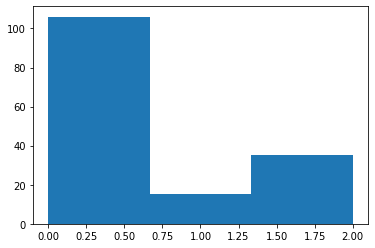

In [74]:
plt.hist(perf_model_small['course_id'],bins=3)

(array([ 1.,  0.,  1.,  0.,  3.,  3.,  2.,  5.,  7.,  9., 18., 89.,  2.,
         5.,  2.,  0.,  2.,  4.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-0.63855181, -0.58111885, -0.5236859 , -0.46625295, -0.40881999,
        -0.35138704, -0.29395409, -0.23652113, -0.17908818, -0.12165523,
        -0.06422227, -0.00678932,  0.05064363,  0.10807659,  0.16550954,
         0.22294249,  0.28037545,  0.3378084 ,  0.39524135,  0.45267431,
         0.51010726,  0.56754021,  0.62497317,  0.68240612,  0.73983907,
         0.79727203,  0.85470498,  0.91213793,  0.96957089,  1.02700384,
         1.08443679]),
 <a list of 30 Patch objects>)

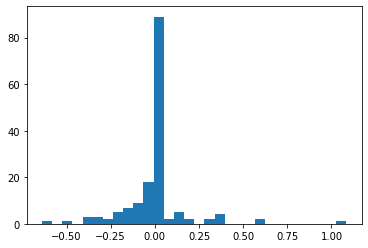

In [75]:
plt.hist(perf_model_small['T_coeff'], bins = 30)

(array([44., 36., 41., 21.,  5.,  3.,  2.,  1.,  2.,  1.]),
 array([ 1.11122208,  5.50009987,  9.88897766, 14.27785545, 18.66673325,
        23.05561104, 27.44448883, 31.83336662, 36.22224442, 40.61112221,
        45.        ]),
 <a list of 10 Patch objects>)

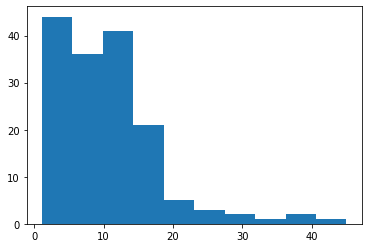

In [76]:
plt.hist(perf_model_small['mse'])

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1., 111.,
          9.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-4173.53015257, -3773.47145555, -3373.41275853, -2973.35406151,
        -2573.29536449, -2173.23666747, -1773.17797045, -1373.11927344,
         -973.06057642,  -573.0018794 ,  -172.94318238,   227.11551464,
          627.17421166,  1027.23290868,  1427.2916057 ,  1827.35030272,
         2227.40899974,  2627.46769676,  3027.52639378,  3427.5850908 ,
         3827.64378782,  4227.70248484,  4627.76118185,  5027.81987887,
         5427.87857589,  5827.93727291,  6227.99596993,  6628.05466695,
         7028.11336397,  7428.17206099,  7828.23075801]),
 <a list of 30 Patch objects>)

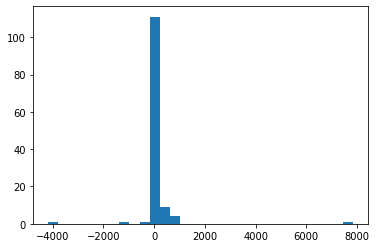

In [77]:
plt.hist(perf_model_small['precip_coeff'], bins = 30)

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  2.,  5., 97., 25.,  7.,
         4.,  5.,  1.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-3.98889445, -3.61507389, -3.24125334, -2.86743278, -2.49361222,
        -2.11979167, -1.74597111, -1.37215056, -0.99833   , -0.62450944,
        -0.25068889,  0.12313167,  0.49695223,  0.87077278,  1.24459334,
         1.6184139 ,  1.99223445,  2.36605501,  2.73987557,  3.11369612,
         3.48751668,  3.86133724,  4.23515779,  4.60897835,  4.98279891,
         5.35661946,  5.73044002,  6.10426058,  6.47808113,  6.85190169,
         7.22572225]),
 <a list of 30 Patch objects>)

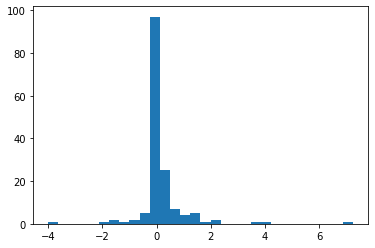

In [78]:
plt.hist(perf_model_small['wspd_coeff'], bins = 30)

(array([ 1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  2.,  1.,  5.,
         2.,  6., 93.,  9., 11.,  8.,  4.,  3.,  1.,  2.,  0.,  1.,  1.,
         0.,  0.,  0.,  1.]),
 array([-1.25294452, -1.17311332, -1.09328212, -1.01345093, -0.93361973,
        -0.85378853, -0.77395734, -0.69412614, -0.61429494, -0.53446374,
        -0.45463255, -0.37480135, -0.29497015, -0.21513895, -0.13530776,
        -0.05547656,  0.02435464,  0.10418584,  0.18401703,  0.26384823,
         0.34367943,  0.42351062,  0.50334182,  0.58317302,  0.66300422,
         0.74283541,  0.82266661,  0.90249781,  0.98232901,  1.0621602 ,
         1.1419914 ]),
 <a list of 30 Patch objects>)

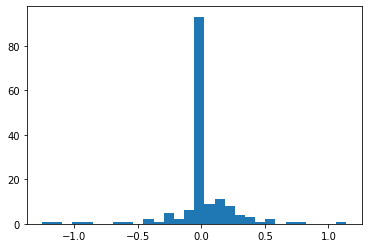

In [79]:
plt.hist(perf_model_small['wgust_coeff'], bins = 30)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   5.,   6., 110.,  13.,   7.,   5.,
          1.,   1.,   2.,   0.,   1.,   0.,   0.,   1.]),
 array([-0.01632131, -0.015445  , -0.01456869, -0.01369238, -0.01281607,
        -0.01193976, -0.01106345, -0.01018714, -0.00931083, -0.00843452,
        -0.00755821, -0.0066819 , -0.00580559, -0.00492928, -0.00405297,
        -0.00317666, -0.00230035, -0.00142404, -0.00054773,  0.00032858,
         0.00120489,  0.0020812 ,  0.00295751,  0.00383382,  0.00471013,
         0.00558644,  0.00646275,  0.00733905,  0.00821536,  0.00909167,
         0.00996798]),
 <a list of 30 Patch objects>)

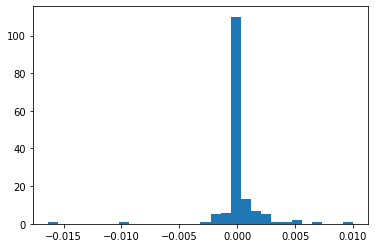

In [80]:
plt.hist(perf_model_small['dirvar_coeff'], bins = 30)

(array([70.,  9., 14., 20.,  7., 10.,  6.,  7.,  5.,  8.]),
 array([0.        , 0.09959744, 0.19919488, 0.29879232, 0.39838976,
        0.49798719, 0.59758463, 0.69718207, 0.79677951, 0.89637695,
        0.99597439]),
 <a list of 10 Patch objects>)

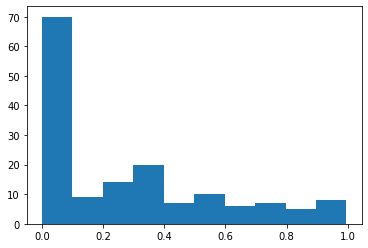

In [81]:
plt.hist(perf_model_small['prediction_score'])

In [82]:
coeff_count = []
for row in perf_model_small.iterrows():
    tmp_count = 0
    if row[1]['cumgame_coeff'] and (abs(row[1]['cumgame_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['T_coeff'] and (abs(row[1]['T_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['precip_coeff'] and (abs(row[1]['precip_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['wgust_coeff'] and (abs(row[1]['wgust_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['wspd_coeff'] and (abs(row[1]['wspd_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['dirvar_coeff'] and (abs(row[1]['dirvar_coeff']) > 0.000001):
        tmp_count += 1
    coeff_count.append(tmp_count)
perf_model_small['coeff_count'] = coeff_count
perf_model_small.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,coeff_count
5,-0.220851,2,NaN,0.001493,62.754570,0.90,8.452737,23,Bob Montes,13.181316,0.394270,0.0,0.513712,0.000000,4
6,-0.052881,0,NaN,0.000074,52.337886,0.10,2.180072,11,Dennis Warsen,3.755786,0.333867,0.0,0.089898,0.125774,5
7,-0.301854,1,NaN,-0.000468,73.440207,0.99,4.008402,14,Dennis Warsen,NaN,0.751378,1.0,0.749217,-1.041771,4
8,-0.000000,2,NaN,-0.000454,52.017011,0.99,12.643779,53,Dennis Warsen,0.000000,0.206196,0.0,0.316280,0.000000,2
10,0.000000,1,NaN,0.001268,67.236154,0.99,5.637292,8,Gonzalo Arestizabal,NaN,0.549017,1.0,-0.856993,1.077261,3


In [83]:
perf_model_small.coeff_count.value_counts()

0    55
5    37
4    21
1    20
3    13
2    10
Name: coeff_count, dtype: int64

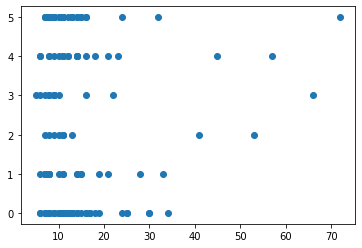

In [84]:
plt.scatter(x=perf_model_small.n_values, y=perf_model_small.coeff_count)

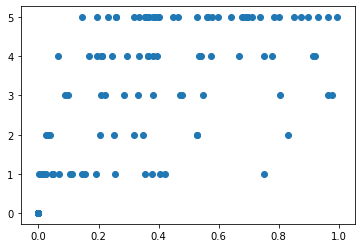

In [85]:
plt.scatter(x=perf_model_small.prediction_score, y=perf_model_small.coeff_count)

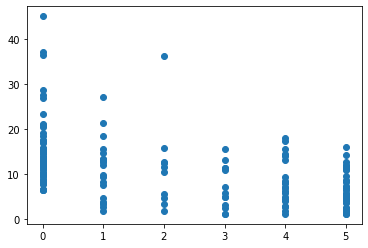

In [86]:
plt.scatter(x=perf_model_small.coeff_count, y=perf_model_small.mse)

In [87]:
perf_model_small.mse.mean()

10.552051925360393

In [88]:
perf_model_small.mean()

T_coeff             -0.010162
course_id            0.544872
cumgame_coeff             NaN
dirvar_coeff         0.000119
intercept           57.699373
l1                   0.336987
mse                 10.552052
n_values            14.019231
precip_coeff        81.962186
prediction_score     0.269703
removed_corr         0.185897
wgust_coeff          0.009092
wspd_coeff           0.194459
coeff_count          2.230769
dtype: float64

In [89]:
perf_model_small.std()

T_coeff               0.176221
course_id             0.837376
cumgame_coeff              NaN
dirvar_coeff          0.002078
intercept            11.118589
l1                    0.359030
mse                   7.537882
n_values             10.247562
precip_coeff        812.118072
prediction_score      0.299308
removed_corr          0.406472
wgust_coeff           0.261863
wspd_coeff            0.937571
coeff_count           2.066152
dtype: float64

In [90]:
perf_model_small[['player','course_id','mse','coeff_count']].sort_values(by='mse')

,player,course_id,mse,coeff_count
783,Bryan Schmitz,0,1.111222,5
705,Mike Sale,0,1.111222,5
62,David Welty,2,1.111222,4
133,Matty Angell,1,1.111222,3
23,Juan Fielding,2,1.111222,3
969,Jake Ward,0,1.297776,5
789,Chris Johengen,0,1.530759,5
1074,Randy Waters,0,1.640871,2
1023,Marquis Mallen,0,1.691784,5
768,Ashley Foust,0,1.717236,4


In [91]:
perf_model_small.sort_values(by='prediction_score',ascending=False).head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,coeff_count
783,0.619207,0,NaN,-0.002071,36.348036,0.10,1.111222,7,Bryan Schmitz,15.238612,0.995974,0.0,-0.278863,-1.491094,5
23,-0.384312,2,NaN,0.000656,75.094111,0.20,1.111222,6,Juan Fielding,NaN,0.976944,1.0,-0.000000,-0.012879,3
705,-0.194285,0,NaN,-0.016321,63.726377,0.50,1.111222,7,Mike Sale,-1165.648202,0.965164,0.0,0.014565,-0.204936,5
133,-0.016361,1,NaN,NaN,54.399915,0.20,1.111222,5,Matty Angell,NaN,0.964013,2.0,0.288358,1.228147,3
338,-0.059334,2,NaN,0.004913,44.589390,0.99,1.929633,13,Roger Cansler,314.913167,0.932427,0.0,-1.117525,7.225722,5


In [92]:
perf_model_df.mean()

T_coeff             -0.010162
course_id            1.000000
cumgame_coeff        0.126866
dirvar_coeff         0.000115
intercept           61.651663
l1                   0.335478
mse                 22.737460
n_values             2.109731
precip_coeff        81.781619
prediction_score     0.281513
removed_corr         0.258929
wgust_coeff          0.009287
wspd_coeff           0.193927
dtype: float64

In [49]:
perf_model_df.std()

T_coeff               0.176221
course_id             0.816778
cumgame_coeff         1.530748
dirvar_coeff          0.002071
intercept             9.367339
mse                  15.352211
n_values              5.458251
precip_coeff        808.942115
prediction_score      0.295650
removed_corr          0.468669
wgust_coeff           0.261034
wspd_coeff            0.934584
dtype: float64

In [50]:
perf_model_with_zeros = perf_model_df.fillna(0)
perf_model_with_zeros.head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
0,0.0,0,0.0,0.000000,68.111111,18.361111,0,Ben Horst,0.000000,0.000000,0.0,0.000000,0.000000
1,0.0,1,0.0,0.000000,68.111111,18.361111,0,Ben Horst,0.000000,0.000000,0.0,0.000000,0.000000
2,0.0,2,0.0,-0.000382,67.739914,14.874146,9,Ben Horst,58.668984,0.088649,1.0,0.039611,0.110993
3,0.0,0,0.0,0.000000,54.607143,14.025132,0,Bob Montes,0.000000,0.000000,0.0,0.000000,0.000000
4,0.0,1,0.1,0.000000,52.400000,6.620000,5,Bob Montes,0.000000,0.003012,1.0,0.000000,0.000000


In [51]:
perf_model_df['mse'].value_counts().sort_index().head()

1.111222    68
1.260000     1
1.297776     1
1.333333     2
1.333333     1
Name: mse, dtype: int64

In [52]:
perf_model_with_zeros.to_csv('../score_model_data/score_model.csv')
perf_model_with_zeros.to_csv('../score_model_data/score_model_20190804a.csv')
len(perf_model_with_zeros)

1449

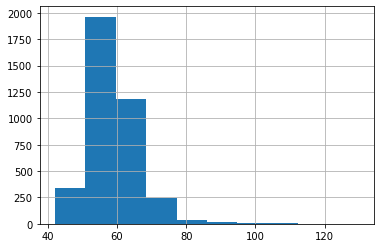

In [53]:
scores_df.Raw.hist()